# Planetary Data Analysis Notebook

For the first part of this script, I will solely focus on the kNN supervised learning technique applied to the data pertaining to exoplanets from NASA.

In [2]:
# Import necessary libraries
from random import seed
from random import randrange
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from  sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from math import sqrt
#import plotly.express as px

In [3]:
# Assign path of data to a variable.
# Initiate first data frame with raw data.
seed(11)
path = 'https://raw.githubusercontent.com/jbravo87/blog-projects/main/data/PS_2022.05.10_21.48.38.csv'
raw_data = pd.read_csv(path, skiprows = 12)

Need to remove the first twelve rows. These rows contain copious notes/remarks. Want to see the head and tail of the data as well as the column names.

In [4]:
raw_data

,pl_name,hostname,pl_orbper,pl_bmassj,pl_orbeccen,pl_eqt
0,11 Com b,11 Com,326.03000,19.40,0.231,NaN
1,11 Com b,11 Com,NaN,17.10,NaN,NaN
2,11 UMi b,11 UMi,NaN,10.80,NaN,NaN
3,11 UMi b,11 UMi,516.21997,14.74,0.080,NaN
4,11 UMi b,11 UMi,516.22000,10.50,0.080,NaN
...,...,...,...,...,...,...
32511,ups And d,ups And,1282.41000,4.10,0.294,NaN
32512,ups And d,ups And,1281.50700,10.25,0.316,NaN
32513,ups Leo b,ups Leo,385.20000,0.51,0.320,NaN
32514,xi Aql b,xi Aql,NaN,2.02,NaN,NaN


In [5]:
raw_data.columns

Index(['pl_name', 'hostname', 'pl_orbper', 'pl_bmassj', 'pl_orbeccen',
       'pl_eqt'],
      dtype='object')

Now want to create first data frame with columns of interest. In this first case/scenario want to study planet eccentricity (dependent/response variable) as a function of orbital period of planet (independent/predictor variable).

In [6]:
df1 = raw_data.loc[:, ['pl_name','pl_orbper','pl_orbeccen']]
#df1.reset_index(drop=True, inplace=True) # <- Perhaps use this logic in a couple of lines.
df1

,pl_name,pl_orbper,pl_orbeccen
0,11 Com b,326.03000,0.231
1,11 Com b,NaN,NaN
2,11 UMi b,NaN,NaN
3,11 UMi b,516.21997,0.080
4,11 UMi b,516.22000,0.080
...,...,...,...
32511,ups And d,1282.41000,0.294
32512,ups And d,1281.50700,0.316
32513,ups Leo b,385.20000,0.320
32514,xi Aql b,NaN,NaN


Will rename the columns of interest for ease, i.e. make analysis clearer, and remove unnecessary rows by removing all the NA values from the original data frame.

In [7]:
df1 = df1.rename(columns={'pl_name':'planetname', 'pl_orbper':'orbitperiod', 'pl_orbeccen':'eccentricity'})
df1 = df1.dropna()
df1

,planetname,orbitperiod,eccentricity
0,11 Com b,326.03000,0.2310
3,11 UMi b,516.21997,0.0800
4,11 UMi b,516.22000,0.0800
6,14 And b,185.84000,0.0000
7,14 Her b,1766.41000,0.3674
...,...,...,...
32510,ups And d,1274.60000,0.2420
32511,ups And d,1282.41000,0.2940
32512,ups And d,1281.50700,0.3160
32513,ups Leo b,385.20000,0.3200


The following logic is to determine the data types of the column entries in the latest data frame. Again, this is the data type (dtype) for individual entries within the data frame.

In [8]:
print(type(df1.iloc[0][1]))
print(type(df1.iloc[0][2]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [9]:
type(df1)

pandas.core.frame.DataFrame

In [10]:
print("The data type of the eccentricity column is:", df1.dtypes['eccentricity'])

The data type of the eccentricity column is: float64


Notice df1 is indeed a data frame, and the entries within are numpy float number type.

Want to limit each scenario to two dataframes. Once cleaned, need another to take arithmetic mean of multiple entries. For example, Dataframe 2 will take the averages of multiple planet entries. Following lines will take arithmetic mean of the two columns of interest and concate the two columns into the third dataframe.

First will create intermediate variables to store the resulting averages.

In [11]:
#x4 = df2.groupby('planetname')['eccentricity'].mean()
eccen = df1.groupby('planetname')['eccentricity'].mean()
#x5 = df2.groupby('planetname')['orbitperiod'].mean()
orbper = df1.groupby('planetname')['orbitperiod'].mean()

In [12]:
print(eccen)
print(orbper)

planetname
11 Com b      0.231000
11 UMi b      0.080000
14 And b      0.000000
14 Her b      0.362233
16 Cyg B b    0.676033
                ...   
ups And b     0.030200
ups And c     0.238933
ups And d     0.281117
ups Leo b     0.320000
xi Aql b      0.000000
Name: eccentricity, Length: 4371, dtype: float64
planetname
11 Com b       326.030000
11 UMi b       516.219985
14 And b       185.840000
14 Her b      1766.601670
16 Cyg B b     799.375000
                 ...     
ups And b        4.616229
ups And c      240.728533
ups And d     1285.346167
ups Leo b      385.200000
xi Aql b       136.750000
Name: orbitperiod, Length: 4371, dtype: float64


In [13]:
type(eccen)

pandas.core.series.Series

In [14]:
type(orbper)

pandas.core.series.Series

In [15]:
df2 = pd.concat([orbper, eccen], axis = 1)
df2

,orbitperiod,eccentricity
planetname,,
11 Com b,326.030000,0.231000
11 UMi b,516.219985,0.080000
14 And b,185.840000,0.000000
14 Her b,1766.601670,0.362233
16 Cyg B b,799.375000,0.676033
...,...,...
ups And b,4.616229,0.030200
ups And c,240.728533,0.238933
ups And d,1285.346167,0.281117


All the filtering and cleaning was handled by df2.

In [16]:
df2.columns

Index(['orbitperiod', 'eccentricity'], dtype='object')

(array([4.37e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([9.07062900e-02, 1.79000082e+05, 3.58000073e+05, 5.37000063e+05,
        7.16000054e+05, 8.95000045e+05, 1.07400004e+06, 1.25300003e+06,
        1.43200002e+06, 1.61100001e+06, 1.79000000e+06]),
 <BarContainer object of 10 artists>)

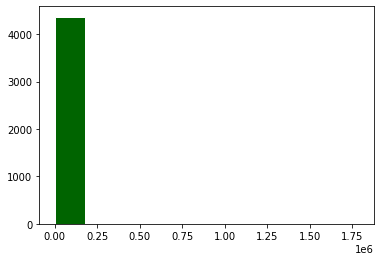

In [17]:
plt.hist(df2.orbitperiod, color = "darkgreen", edgecolor = 'white')

(array([1.100e+01, 4.260e+02, 1.905e+03, 1.158e+03, 4.170e+02, 3.240e+02,
        1.140e+02, 1.400e+01, 1.000e+00, 1.000e+00]),
 array([-2.40012857, -0.7203431 ,  0.95944238,  2.63922785,  4.31901333,
         5.9987988 ,  7.67858428,  9.35836975, 11.03815523, 12.7179407 ,
        14.39772618]),
 <BarContainer object of 10 artists>)

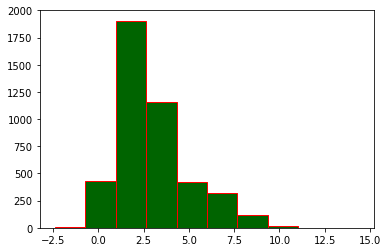

In [18]:
orbper_log = np.log(orbper)
plt.hist(orbper_log, color = "darkgreen", edgecolor = 'red')

The orbital period is skewed right, but after applying a log transform, the distribution more closely resembles a Gaussian distribution.

Going add 10 to every element in the array so as to be able to perform Log Transform on the eccentricity dataset as well.

(array([3437.,  366.,  238.,  121.,   76.,   49.,   34.,   22.,   16.,
          12.]),
 array([2.30258509, 2.31149493, 2.32040476, 2.3293146 , 2.33822443,
        2.34713427, 2.3560441 , 2.36495394, 2.37386377, 2.38277361,
        2.39168344]),
 <BarContainer object of 10 artists>)

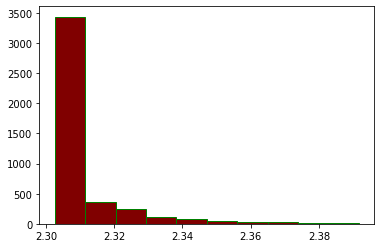

In [37]:
eccen_2 = eccen + 10
eccen_log = np.log(eccen_2)
plt.hist(eccen_log, color = "maroon", edgecolor = 'green')

The distribution is still skewed right after applying the transform.

#### Model Building

Will implement robust scaling to deal with outliers.

As a resampling method, will use the train-test-split (tts) method. Will bundle the logic of tts into a function.

In [20]:
def tts(data, split = 0.80):
    train = list()
    train_size = split*len(data)
    data_copy = list(data)
    while len(train) < train_size :
        index = randrange(len(data_copy))
        train.append(data_copy.pop(index))
    return np.array(train), np.array(data_copy)

In [38]:
X1_train, X1_test = tts(orbper_log)
#y1_train, y1_test = tts(eccen)
y1_train, y1_test = tts(eccen_log)
#rs = RobustScaler()
#scale_X1_train = rs.fit_transform(X1_train.reshape(-1, 1))
#scale_y1_train = rs.fit_transform(y1_train.reshape(-1, 1))
#scale_X1_test = rs.fit_transform(X1_test.reshape(-1, 1))
#scale_X1_train

In [39]:
model_knn1 = KNeighborsRegressor(n_neighbors = 27)
model_knn1.fit(X1_train.reshape(-1, 1), y1_train.reshape(-1, 1))
y_knn_train_pred_1 = model_knn1.predict(X1_train.reshape(-1, 1))
y_knn_test_pred_1 = model_knn1.predict(X1_test.reshape(-1, 1))
y_knn_test_pred_1

array([[2.3098011 ],
       [2.3099433 ],
       [2.31002858],
       [2.3097758 ],
       [2.31242952],
       [2.3099433 ],
       [2.30942043],
       [2.31018033],
       [2.30903791],
       [2.30742991],
       [2.30876441],
       [2.30568251],
       [2.31052083],
       [2.31288155],
       [2.30877509],
       [2.30635586],
       [2.30746876],
       [2.31020011],
       [2.30734082],
       [2.3106391 ],
       [2.3046742 ],
       [2.30829573],
       [2.30433545],
       [2.30517132],
       [2.31174779],
       [2.30807754],
       [2.30472355],
       [2.30957389],
       [2.30741668],
       [2.30603465],
       [2.30711144],
       [2.30817497],
       [2.31165024],
       [2.30701295],
       [2.31342366],
       [2.30856974],
       [2.31181181],
       [2.31047229],
       [2.31182157],
       [2.31213488],
       [2.31127283],
       [2.31133995],
       [2.31020145],
       [2.30554734],
       [2.30649386],
       [2.31162817],
       [2.30851597],
       [2.305

In [40]:
# Following line to remind myself that values between 0 - 1 will produce negative value in log.
np.log(0.055550)

-2.890471762896498

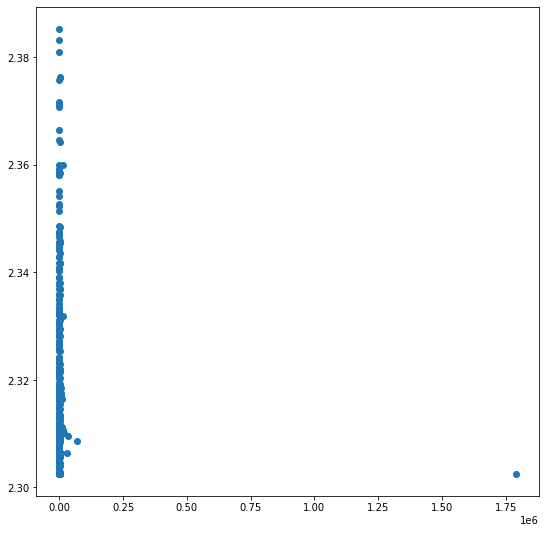

In [41]:
# Following to 'unscale' the fitted data
# The y-values are the actual test data.
inverse_X1test = np.exp(X1_test)
inverse_knn_model_1 = np.exp(y_knn_test_pred_1)
plt.figure(figsize = (9, 9))
plt.scatter(inverse_X1test, y1_test)

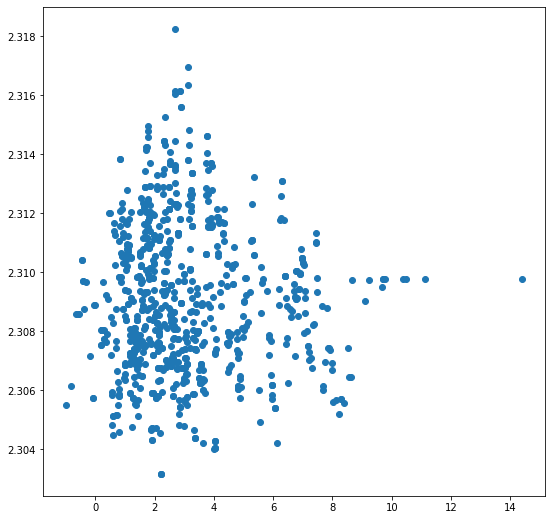

In [45]:
plt.figure(figsize = (9, 9))
plt.scatter(X1_test, y_knn_test_pred_1)
#plt.scatter(inverse_X1test, inverse_knn_model_1)

Want to make a quick calculation of the residuals in this prediction and actual values evaluation.

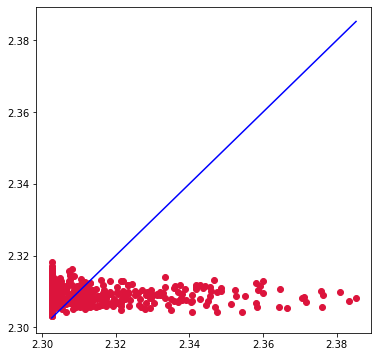

In [43]:
true_values_1 = y1_test
predicted_values1_1 = y_knn_test_pred_1
plt.figure(figsize = (6, 6))
plt.scatter(true_values_1, predicted_values1_1, c = 'crimson')
p1 = max(max(predicted_values1_1), max(true_values_1))
p2 = min(min(predicted_values1_1), min(true_values_1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.show()

Want to plot the residuals and see if there are any obvious patterns. Another name is the Versus Fit.

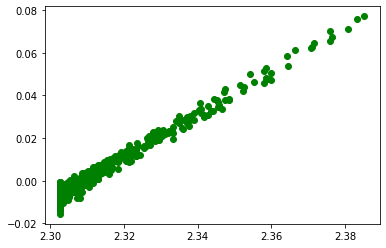

In [81]:
#residuals1_1 = np.subtract(true_values_1, predicted_values1_1)
residuals1_1 = list()
for item1, item2 in zip(true_values_1, predicted_values1_1):
    residuals1_1.append(item1 - item2)
plt.scatter(true_values_1, residuals1_1, c = 'green')

There is an obvious pattern in the residuals plot.

In [82]:
knn1_train_mse = mean_squared_error(y1_train, y_knn_train_pred_1)
knn1_train_r2 = r2_score(y1_train, y_knn_train_pred_1)
# Now, test mean square and r2 score.
knn1_test_mse = mean_squared_error(y1_test, y_knn_test_pred_1)
knn1_test_r2 = r2_score(y1_test, y_knn_test_pred_1)
# Consolidate the results.
knn_results_1 = pd.DataFrame(['k Nearest Neighbor', knn1_train_mse, knn1_train_r2, knn1_test_mse, knn1_test_r2]).transpose()
#results_1 = pd.DataFrame(columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2'])
#results1 = pd.DataFrame()
#results_1 = pd.concat([results1, knn_results_1], axis=1)
#results_1.append(knn_results_1, ignore_index=True)
knn_results_1.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
print(knn_results_1)
#knn_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
#print(knn_results)

               Method Training MSE Training R2  Test MSE   Test R2
0  k Nearest Neighbor     0.000164    0.036365  0.000195 -0.056168


In [83]:
knn_results_1

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.000164,0.036365,0.000195,-0.056168


In [17]:
# NB: the independent variable is orbital period (X)
# dependent variable is ecentricity (y)
#X2_train, X2_test = tts(orbper)
#y2_train, y2_test = tts(eccen)
#X2_train, y2_train = pd.DataFrame(X2_train), pd.DataFrame(y2_train)
#X2_test, y2_test = pd.DataFrame(X2_test), pd.DataFrame(y2_test)
#test_set_1 = pd.concat([X2_test, y2_test], axis = 1)
#train_set_1 = pd.concat([X2_train, y2_train], axis = 1)
#df2_scaled = pd.DataFrame(rs.fit_transform(df2_scaled), columns = df2_scaled.columns, index = df2_scaled.index)
#df2_scaled.head()

In [63]:
model_knn1

KNeighborsRegressor(n_neighbors=27)

In [122]:
df1_scaled = train_set_1.copy()
df1_scaled.columns = ['orbitperiod', 'eccentricity']
df1_scaled

,orbitperiod,eccentricity
0,7.126858,0.000000
1,10.526294,0.000000
2,323.600000,0.000000
3,0.837491,0.008333
4,521.000000,0.000000
...,...,...
3492,12.310247,0.000000
3493,858.000000,0.085000
3494,12.455122,0.008333
3495,5.996539,0.200000


In [168]:
col_names = ['orbitperiod', 'eccentricity']
features = df1_scaled[col_names]
rs = RobustScaler()
df1_scaled = rs.fit_transform(features.values)
#df1_scaled

C:\Users\Lbrav\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [124]:
type(df1_scaled)

numpy.ndarray

In [125]:
df1_scaled.shape

(3497, 2)

In [156]:
df1_scaled[:,0].ravel

<function ndarray.ravel>

In [157]:
knn_model_2 = KNeighborsRegressor(n_neighbors = 27)
knn_model_2.fit(df1_scaled[:,0].reshape(-1, 1), df1_scaled[:,1].reshape(-1, 1))
y_knn_test_pred2_scaled = knn_model_2.predict(df1_scaled[:,0].reshape(-1, 1))

In [161]:
y_knn_test_pred2_scaled

array([[0.97408749],
       [1.12050456],
       [1.13427268],
       ...,
       [1.26516371],
       [1.03441582],
       [0.86598676]])

In [159]:
y_knn_test_pred2_scaled.ndim

2

In [120]:
df1_scaled[:,1]

array([ 0.        ,  0.05361039,  0.21441558,  1.27207792,  1.62077922,
        5.45454545,  3.21038961, 11.84415584,  6.07792208,  2.96103896,
        8.41558442,  0.28051948,  8.97142857,  3.03896104,  0.77142857,
        0.12467532,  0.10909091,  1.37922078,  1.09090909,  0.        ,
        0.        ,  0.        ,  8.25974026,  3.9974026 ,  0.87792208,
        4.20779221,  2.95324675,  1.4025974 ,  1.4025974 ,  1.71428571,
        5.99220779,  1.01298701,  3.27272727,  2.64935065,  1.24675325,
        1.09090909,  0.10909091,  2.23636364,  6.23376623,  0.        ,
        6.85714286,  0.65974026,  0.03428571,  1.2       ,  1.55033766,
        0.59906494,  0.7012987 ,  1.41818182,  0.54597403,  0.95064935,
        1.32467532,  1.63636364,  1.91688312,  0.46753247,  1.76103896,
        1.57402597,  4.73766234,  1.4025974 ,  0.06318772,  1.26753247,
        1.32467532,  1.96363636,  0.        ,  2.46233766,  7.34025974,
        1.24675325,  1.68311688,  1.10649351,  3.83376623,  1.29

In [162]:
y_knn_test_pred2_scaled.shape

(3497, 1)

In [165]:
y_knn_test_pred2_scaled[:,0]

array([0.97408749, 1.12050456, 1.13427268, ..., 1.26516371, 1.03441582,
       0.86598676])

In [148]:
some_array = [df1_scaled[:,0],y_knn_test_pred2_scaled]
y_knn_pred2 = rs.inverse_transform(y_knn_test_pred2_scaled)
y_knn_pred2

ValueError: non-broadcastable output operand with shape (3497,1) doesn't match the broadcast shape (3497,2)

In [115]:
X2_test.shape

(874, 1)

In [116]:
type(X2_test)

pandas.core.frame.DataFrame

In [45]:
y2_train.shape

(3497,)

In [46]:
X2_train.shape

(3497,)

In [47]:
type(X2_train)

numpy.ndarray

In [48]:
X2_train

array([  3.22296883,   2.36435893,   5.90223911, ...,   3.75083193,
       177.6690598 ,   2.032046  ])

In [117]:
# kNN R-squared accuracy
knn_r_acc = []
for i1 in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i1)
    knn.fit(X2_train.reshape(-1, 1), y2_train.reshape(-1, 1))
    test_score = knn.score(X2_test.reshape(-1, 1), y2_test.reshape(-1, 1))
    train_score = knn.score(X2_train.reshape(-1, 1), y2_train.reshape(-1, 1))
    knn_r_acc.append((i1, test_score, train_score))
outcomes = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes)
print('The highest Test R-squared value occurs at : %.4f' % outcomes.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes.loc[outcomes['Test Score'] == outcomes.iloc[:,1].max(), 'k'].iloc[0])

AttributeError: 'DataFrame' object has no attribute 'reshape'

Notice that the above block of code determines optimal k for kNN without the use of scaling. I did this same algorithm after scaling and the R-squared values obtained were incosistent.

In [93]:
training_scaled = [X2_train, y2_train]
train_x_scale = rs.transform(training_scaled)
rs1_1 = RobustScaler().fit(X2_train.reshape(-1, 1))
rs1_2 = RobustScaler().fit(y2_train.reshape(-1, 1))
rs1_3 = RobustScaler().fit(X2_test.reshape(-1, 1))
rs1_4 = RobustScaler().fit(y2_test.reshape(-1, 1))
# Transformer1 is the x2 train scaled data, and transformer 2 is the y2 training data scaled.
# Similar logic for the testing data sets.
x2_train_scale = rs1_1.transform(X2_train.reshape(-1, 1))
y2_train_scale = rs1_2.transform(y2_train.reshape(-1, 1))
x2_test_scale = rs1_3.transform(X2_test.reshape(-1, 1))
y2_test_scale = rs1_4.transform(y2_test.reshape(-1, 1))

In [94]:
x2_train_scale

array([[-0.22380977],
       [-0.24508849],
       [-0.15741007],
       ...,
       [-0.21072787],
       [ 4.09944505],
       [-0.25332412]])

In [95]:
x2_train_scale.shape

(3497, 1)

In [96]:
type(x2_train_scale)

numpy.ndarray

In [98]:
x2_train_scale

array([[-0.22380977],
       [-0.24508849],
       [-0.15741007],
       ...,
       [-0.21072787],
       [ 4.09944505],
       [-0.25332412]])

In [99]:
# kNN R-squared accuracy
knn_r_acc = []
for i in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(x2_train_scale, y2_train_scale)
    test_score = knn.score(x2_test_scale, y2_test_scale)
    train_score = knn.score(x2_train_scale, y2_train_scale)
    knn_r_acc.append((i, test_score, train_score))
outcomes = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes)
print('The highest Test R-squared value occurs at : %.4f' % outcomes.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes.loc[outcomes['Test Score'] == outcomes.iloc[:,1].max(), 'k'].iloc[0])

     k  Test Score  Train Score
0    1   -0.764313     1.000000
1    2   -0.317484     0.490710
2    3   -0.230256     0.335282
3    4   -0.160265     0.248368
4    5   -0.157203     0.190544
..  ..         ...          ...
69  70   -0.024602     0.008875
70  71   -0.024775     0.009195
71  72   -0.024569     0.009589
72  73   -0.023090     0.009108
73  74   -0.022380     0.008762

[74 rows x 3 columns]
The highest Test R-squared value occurs at : -0.0221
Within given range, optimal k is:  59


In [100]:
knn_model_2 = KNeighborsRegressor(n_neighbors = 59)
knn_model_2.fit(x2_train_scale, y2_train_scale)
y_knn_train_pred2_scaled = knn_model_2.predict(x2_train_scale)
y_knn_test_pred2_scaled = knn_model_2.predict(x2_test_scale)

In [101]:
y_knn_test_pred2_scaled

array([[0.80240632],
       [0.95639052],
       [1.07578962],
       [0.30141243],
       [1.18550511],
       [0.93438526],
       [1.14514643],
       [0.87339387],
       [0.7312781 ],
       [0.82002911],
       [1.07366886],
       [0.74221434],
       [0.8587463 ],
       [0.30141243],
       [1.15659134],
       [0.78667791],
       [0.82859679],
       [0.28728814],
       [0.70010492],
       [1.01219532],
       [1.00748645],
       [0.83372535],
       [0.82384181],
       [1.24675026],
       [0.75754278],
       [1.14514643],
       [1.18550511],
       [1.25171509],
       [0.92733293],
       [0.67228258],
       [1.24845911],
       [0.96898247],
       [1.05782235],
       [0.8109691 ],
       [0.92582324],
       [0.99411872],
       [0.61343019],
       [0.7005102 ],
       [1.14514643],
       [0.80467854],
       [1.06447365],
       [1.03880779],
       [0.80675213],
       [0.78735732],
       [1.12063761],
       [1.02226755],
       [1.38663438],
       [0.887

In [102]:
y_knn_test_pred2_scaled.shape

(874, 1)

In [137]:
type(y_knn_test_pred2_scaled)

numpy.ndarray

In [141]:
y_knn_test_pred2_scaled.ndim

2

In [103]:
y_knn_pred2 = rs1_3.inverse_transform(y_knn_test_pred2_scaled)
y_knn_pred2

array([[41.9522001 ],
       [47.65233573],
       [52.07221132],
       [23.40657629],
       [56.13362278],
       [46.83775219],
       [54.63963868],
       [44.57999333],
       [39.31919972],
       [42.60455481],
       [51.99370581],
       [39.72403374],
       [44.03777467],
       [23.40657629],
       [55.06330236],
       [41.36997109],
       [42.92171036],
       [22.88372791],
       [38.16524135],
       [49.71809897],
       [49.54378773],
       [43.11155767],
       [42.74569186],
       [58.40077512],
       [40.29145654],
       [54.63963868],
       [56.13362278],
       [58.58456166],
       [46.57669151],
       [37.13532311],
       [58.46403266],
       [48.11846039],
       [51.40710515],
       [42.26917425],
       [46.52080649],
       [49.04894553],
       [34.95674497],
       [38.1802439 ],
       [54.63963868],
       [42.03631253],
       [51.65332085],
       [50.70323067],
       [42.113072  ],
       [41.39512116],
       [53.73237939],
       [50

In [105]:
r2_score(x2_test_scale, y_knn_test_pred2_scaled)

-0.001389962287949409

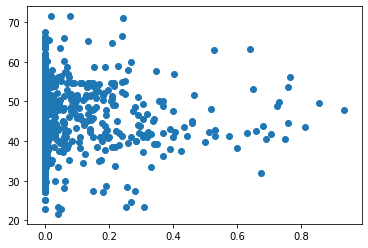

In [107]:
plt.scatter(y2_test, y_knn_pred2)

In [19]:
#X1 = df2_scaled[['orbitperiod']]
#y1 = df2_scaled[['eccentricity']]
X1 = transformer[:,0]
y1 = transformer[:,1]
X1_train, X1_test = tts(X1)
y1_train, y1_test = tts(y1)
X1_train, y1_train = pd.DataFrame(X1_train), pd.DataFrame(y1_train)
X1_test, y1_test = pd.DataFrame(X1_test), pd.DataFrame(y1_test)
print('\nTraining X1 shape: ', X1_train.shape)
print('Training y1 shape: ', y1_train.shape)
print('Test X1 shape: ', X1_test.shape)
print('Test y1 shape: ', y1_test.shape)


Training X1 shape:  (3497, 1)
Training y1 shape:  (3497, 1)
Test X1 shape:  (874, 1)
Test y1 shape:  (874, 1)


In [21]:
y2_test.head()

,0
0,0.000000
1,0.003440
2,0.013758
3,0.081625
4,0.104000


In [25]:
knn_model_2 = KNeighborsRegressor(n_neighbors = 68)
knn_model_2.fit(transformer1[:,0], transformer1[:,1])
y_knn_train_pred2_scaled = knn_model_2.predict(transformer1[:,1])
y_knn_test_pred2_scaled = knn_model_2.predict(transformer2[:,0])

ValueError: Expected 2D array, got 1D array instead:
array=[-0.22136964  0.02103239 -0.11332162 ...  0.49214245  0.22848875
 -0.28230551].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Will run kNN for various values of n_neighbors and store results. This will help me determine optimal 'k'.

In [26]:
# kNN R-squared accuracy
knn_r_acc = []
for i in range(1, 75, 1):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X1_train, y1_train)
    test_score = knn.score(X1_test, y1_test)
    train_score = knn.score(X1_train, y1_train)
    knn_r_acc.append((i, test_score, train_score))
outcomes = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(outcomes)
print('The highest Test R-squared value occurs at : %.4f' % outcomes.iloc[:,1].max())
print('Within given range, optimal k is: ', outcomes.loc[outcomes['Test Score'] == outcomes.iloc[:,1].max(), 'k'].iloc[0])

     k  Test Score  Train Score
0    1   -0.967957     1.000000
1    2   -0.431522     0.490710
2    3   -0.318188     0.335282
3    4   -0.245677     0.248368
4    5   -0.193963     0.190544
..  ..         ...          ...
69  70   -0.017793     0.008875
70  71   -0.016973     0.009194
71  72   -0.017448     0.009592
72  73   -0.017024     0.009108
73  74   -0.015804     0.008762

[74 rows x 3 columns]
The highest Test R-squared value occurs at : -0.0141
Within given range, optimal k is:  27


Logic above details optimal k for building model.
Will now create the kNN model.

In [27]:
knn_model_1 = KNeighborsRegressor(n_neighbors = 68)
knn_model_1.fit(X1_train, y1_train)
y_knn_train_pred1_scaled = knn_model_1.predict(X1_train)
y_knn_test_pred1_scaled = knn_model_1.predict(X1_test)

In [28]:
y_knn_train_pred1_scaled.shape 

(3497, 1)

In [29]:
scaled_pred = np.array(y_knn_test_pred1_scaled)
scaled_pred

array([[0.76143216],
       [1.05132582],
       [1.20835672],
       [0.33132237],
       [1.28043181],
       [1.09163894],
       [0.96036853],
       [0.86788588],
       [0.96337781],
       [0.71491205],
       [0.86938813],
       [0.93480903],
       [0.98473872],
       [0.33132237],
       [1.10523557],
       [0.71722437],
       [0.58739629],
       [0.33132237],
       [0.69385745],
       [1.12892668],
       [0.9046265 ],
       [1.00694306],
       [0.98243976],
       [1.18022807],
       [0.95347644],
       [0.93865307],
       [1.28043181],
       [1.12874454],
       [0.91957625],
       [0.55953908],
       [1.2779785 ],
       [1.2023616 ],
       [0.97788681],
       [0.95207917],
       [1.2932342 ],
       [0.75338829],
       [0.51764297],
       [0.78101079],
       [1.00870976],
       [0.95876273],
       [1.01729048],
       [1.00078644],
       [0.70255924],
       [1.09978653],
       [1.07468203],
       [0.88837708],
       [1.33320058],
       [0.879

In [30]:
scaled_pred.shape

(874, 1)

In [31]:
scaled_pred.ndim

2

In [32]:
transformer.shape

(4371, 2)

In [33]:
y_knn_test_pred1_scaled

array([[0.76143216],
       [1.05132582],
       [1.20835672],
       [0.33132237],
       [1.28043181],
       [1.09163894],
       [0.96036853],
       [0.86788588],
       [0.96337781],
       [0.71491205],
       [0.86938813],
       [0.93480903],
       [0.98473872],
       [0.33132237],
       [1.10523557],
       [0.71722437],
       [0.58739629],
       [0.33132237],
       [0.69385745],
       [1.12892668],
       [0.9046265 ],
       [1.00694306],
       [0.98243976],
       [1.18022807],
       [0.95347644],
       [0.93865307],
       [1.28043181],
       [1.12874454],
       [0.91957625],
       [0.55953908],
       [1.2779785 ],
       [1.2023616 ],
       [0.97788681],
       [0.95207917],
       [1.2932342 ],
       [0.75338829],
       [0.51764297],
       [0.78101079],
       [1.00870976],
       [0.95876273],
       [1.01729048],
       [1.00078644],
       [0.70255924],
       [1.09978653],
       [1.07468203],
       [0.88837708],
       [1.33320058],
       [0.879

In [34]:
y_knn_test_pred1_scaled.shape

(874, 1)

In [207]:
#some_array = np.array([X1_test, y_knn_test_pred1_scaled])
some_array = np.append(X1_test, y_knn_test_pred1_scaled, 1)
type(some_array)

numpy.ndarray

In [208]:
some_array.shape

(874, 2)

In [209]:
some_array

array([[ 9.8618521 ,  1.42107611],
       [11.69273061,  1.13802063],
       [26.81914327,  0.78157994],
       ...,
       [-0.22394611,  0.91477722],
       [-0.19129317,  1.17300437],
       [31.88614754,  0.64886057]])

In [211]:
some_array[:,0]

array([ 9.86185210e+00,  1.16927306e+01,  2.68191433e+01,  5.95807621e-02,
        8.03278260e-01,  2.23020913e+01, -2.01344062e-01,  6.46305474e-01,
       -9.49434720e-02,  1.65434852e-01,  1.17628600e+01,  6.42901752e+00,
        9.20138335e+00,  7.37151862e-01,  2.84740840e+00,  1.55151710e+00,
        1.75836009e+01,  1.61133878e+01, -2.69118400e-01, -2.36080486e-01,
       -2.69038854e-01, -2.35516245e-01, -8.43366994e-02, -1.42007945e-01,
       -1.68757305e-01, -1.76491577e-01, -1.39768813e-01, -1.36630522e-01,
        2.72161357e-02,  9.11117820e+01,  8.44098624e-02,  1.30737790e+01,
        1.90044341e+02,  1.25297813e-01,  1.44559665e+00, -7.63498728e-03,
        1.84730304e+02,  4.59485737e-01,  8.98674920e-01,  7.08461420e-01,
       -2.23337708e-01,  1.73310824e-02,  2.75048560e-02, -2.40792000e-01,
       -8.88147878e-02, -2.28016092e-01,  1.47596400e+01, -1.26573464e-01,
        6.70541447e-01,  6.48438160e-01,  5.86736803e-01, -2.58376557e-01,
        8.20846550e-02,  

In [210]:
z = rs.inverse_transform(transformer)
scaled_testdata = np.append(X1_test, y1_test, 1)
z1 = rs.inverse_transform(scaled_testdata)
z1

array([[4.06000000e+02, 0.00000000e+00],
       [4.79100000e+02, 6.76033333e-01],
       [1.08304000e+03, 8.00000000e-02],
       ...,
       [3.31252124e+00, 1.51000000e-01],
       [4.61622886e+00, 1.72500000e-01],
       [1.28534617e+03, 1.18800000e-02]])

In [202]:
z1.shape

(874, 2)

In [206]:
z1[:,1]

array([0.00000000e+00, 6.76033333e-01, 8.00000000e-02, 2.90000000e-01,
       3.80000000e-01, 4.12000000e-02, 2.70000000e-01, 1.37583333e-02,
       1.14990000e-01, 1.04000000e-01, 1.40000000e-01, 5.00000000e-02,
       2.00000000e-01, 7.60000000e-01, 2.70000000e-01, 5.00000000e-02,
       1.20000000e-01, 3.35000000e-02, 5.15000000e-02, 5.75666667e-01,
       0.00000000e+00, 5.90000000e-02, 1.01000000e-01, 8.00000000e-03,
       7.00000000e-02, 6.00000000e-02, 1.25666667e-01, 0.00000000e+00,
       3.45000000e-01, 7.80000000e-02, 2.00000000e-01, 9.00000000e-02,
       7.00000000e-02, 0.00000000e+00, 3.53333333e-01, 2.56500000e-01,
       9.90000000e-02, 9.00000000e-02, 9.00000000e-02, 1.00000000e-01,
       1.90000000e-01, 1.20000000e-01, 6.06666667e-02, 0.00000000e+00,
       0.00000000e+00, 6.25000000e-02, 7.00000000e-02, 1.00000000e-01,
       5.00000000e-02, 8.00000000e-02, 3.26750000e-01, 4.20000000e-02,
       1.80000000e-01, 2.90000000e-01, 0.00000000e+00, 0.00000000e+00,
      

In [203]:
y_knn_pred1.shape

(874, 2)

In [192]:
y_knn_pred1 = rs.inverse_transform(some_array)
#y_knn_pred1 = rs.inverse_transform(y_knn_test_pred1_scaled)

In [195]:
print(y_knn_pred1)

[[4.06000000e+02 9.37022059e-02]
 [4.79100000e+02 7.50382353e-02]
 [1.08304000e+03 5.15354272e-02]
 ...
 [3.31252124e+00 6.03181232e-02]
 [4.61622886e+00 7.73449755e-02]
 [1.28534617e+03 4.27842437e-02]]


In [213]:
y_knn_pred1[:,1]

array([0.09370221, 0.07503824, 0.05153543, 0.04033162, 0.06442305,
       0.07683971, 0.05345914, 0.04995214, 0.06857621, 0.07024551,
       0.07503824, 0.04123444, 0.08400613, 0.06758912, 0.07059013,
       0.0519799 , 0.0793966 , 0.07803631, 0.06996101, 0.07233711,
       0.06996101, 0.0620577 , 0.05362584, 0.08120686, 0.06748338,
       0.0528167 , 0.07603039, 0.0704299 , 0.0518436 , 0.06650483,
       0.04644039, 0.06839513, 0.05185606, 0.05512765, 0.04096294,
       0.05151039, 0.05185606, 0.02231156, 0.06272676, 0.04935088,
       0.06352401, 0.05086949, 0.0518436 , 0.07687643, 0.04687167,
       0.0722946 , 0.06325322, 0.05001824, 0.05097834, 0.04974136,
       0.03265658, 0.05818276, 0.05748451, 0.08676716, 0.07339593,
       0.07062695, 0.06276682, 0.07031765, 0.08045527, 0.0750056 ,
       0.04909779, 0.07142924, 0.07830539, 0.04622712, 0.08146736,
       0.05730212, 0.06031812, 0.07077844, 0.09593517, 0.06223781,
       0.04935886, 0.04626691, 0.06052728, 0.07272733, 0.06959

In [115]:
plt.scatter(z1[:,1], y_knn_pred1[:,1])
plt(axis='equal)')

NameError: name 'z1' is not defined

In [29]:
y_knn_test_pred1_scaled.shape 

(874, 1)

In [29]:
len(df2_scaled)

4371

pandas.core.series.Series

In [114]:
print(y_knn_train_pred1_scaled.ravel)

<built-in method ravel of numpy.ndarray object at 0x000001DD94F1A150>


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>]], dtype=object)

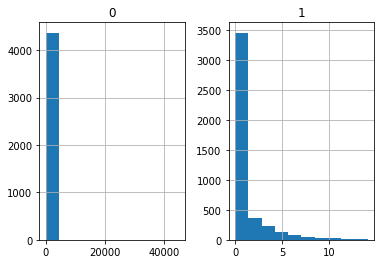

In [25]:
df3 = pd.DataFrame(scaled_data)
df3.hist()

In [26]:
df3

,0,1
0,7.858906,3.503318
1,12.622446,1.213270
2,4.347677,0.000000
3,43.939778,5.493586
4,19.714408,10.252638
...,...,...
4366,-0.191293,0.458009
4367,5.722427,3.623633
4368,31.886148,4.263381
4369,9.340891,4.853081


In this part want to explicitly declare the median and IQR of the two columns which are the variables. But the summary statistics part of the analysis can be done with variables declared earlier.

In [39]:
ecce = df2['eccentricity']
orbper = df2['orbitperiod']
eccen_med = statistics.median(list(ecce))
orbper_med = statistics.median(list(orbper))
print('\nThe median of the orbital period: %.4f' % orbper_med)
print('\nThe median of the eccentricity: %.2f' % eccen_med)
iqr_ecce = stats.iqr(ecce, interpolation = 'midpoint')
iqr_op = stats.iqr(orbper, interpolation = 'midpoint')
print('\nThe interquartile range of the eccentricity: %.2f' % iqr_ecce)
print('\nThe interquartile range of the orbital period: %.2f' % iqr_op)


The median of the orbital period: 12.2538

The median of the eccentricity: 0.00

The interquartile range of the eccentricity: 0.07

The interquartile range of the orbital period: 39.93


In [40]:
ecce_mode = statistics.mode(list(ecce))
print('The mode of the eccentricity: \n%.2f' %ecce_mode)

The mode of the eccentricity: 
0.00


In [41]:
ecce_avg = statistics.mean(list(ecce))
ecce_avg

0.0640127391709691

In [42]:
plt.hist(df3.eccentricity, color = "darkgreen")

AttributeError: 'DataFrame' object has no attribute 'eccentricity'

The next section of code will use Robust Scaling to properly scale the dataframe. I want to use the kNN supervised learning model, but it is distance based and thus sensitive to scale of the data points.

In [43]:
x6 = df3[['orbitperiod', 'eccentricity']]
x6

KeyError: "None of [Index(['orbitperiod', 'eccentricity'], dtype='object')] are in the [columns]"

In [ ]:
rs = RobustScaler().fit(x6)
transformer = rs.transform(x6)

In [ ]:
type(transformer)

In [35]:
len(transformer)

1758

In [36]:
transformer

array([[ 0.76860204,  0.68780488],
       [ 1.24344198, -0.04878049],
       [ 0.4185951 , -0.43902439],
       ...,
       [ 3.14150382,  1.01804878],
       [ 0.91632949,  1.12195122],
       [ 0.296034  , -0.43902439]])

In [37]:
transformer.shape

(1758, 2)

In [38]:
X = transformer[:, 0]
y = transformer[:, 1]

Now to split the data into training and testing using the test-train-split function defined earlier in the script.

In [39]:
x_train, x_test = tts(X)
y_train, y_test = tts(y)

In [40]:
type(x_train)

numpy.ndarray

In [41]:
type(x_test)

numpy.ndarray

In [42]:
print(x_train)

[ 2.14755861e+01 -4.52660169e-03  1.38715049e+01 ... -3.95095648e-02
  8.14459594e-02  4.58442424e+00]


In [43]:
# Generate random predictions.
def random_algorithm(train, test):
    #output_values = [row[-1] for row in train]
    output_values = [row[-1] for row in train]
    unique = list(set(output_values))
    predicted = list()
    for row in test:
        index = randrange(len(unique))
        predicted.append(unique[index])
    return predicted

In [44]:
def the_real_random_algo(train_list, test_list):
    predicted = []
    for row in test_list:
        index = randrange(len(train_list))
        predicted.append(train_list[index])
    return predicted

For regression problem, the mean of the target (dependent variable) values can serve as a good baseline.

In [45]:
#y_pred = y_train.mean()
y_pred = y.mean() # <- this method is probably best practice as opposed to line above.
y_pred

0.3131393767862593

In [46]:
x6.orbitperiod.mean()

1652.9983609162173

In [47]:
y_pred2 = [y_pred] * len(y_train)
y_pred2

[0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767862593,
 0.3131393767

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [49]:
# Error for training data baseline guess.
mean_abs_err = mean_absolute_error(y_train, y_pred2)
mean_abs_err

0.6776630275347485

So MAE is 0.6799 so the models we work with want to have a lower MAE

In [50]:
# Mean squared error for training data baseline guess.
mean_sqrd = mean_squared_error(y_train, y_pred2)
mean_sqrd

0.8305670576052493

So our mean squared error is 0.8305.

Now want to obtian metric for test data set.


In [51]:
# Prediction for y_test
y_pred3 = [y_pred] * len(y_test)
y_pred3
# Mean absolute error for test data
mae = mean_absolute_error(y_test, y_pred3)
# Mean squared error for test data
mse = mean_squared_error(y_test, y_pred3)
print(f'mae: {mae} \nMSE: {mse}')

mae: 0.6262174485080225 
MSE: 0.636238215035512


Notice MAE for test data is slightly lower than MAE for training data.
i.e. 0.626 < 0.678

In [52]:
y_test_r2 = r2_score(y_test, y_pred3)
print(f'Test Set R2: {y_test_r2}')

Test Set R2: -0.0013748157235968783


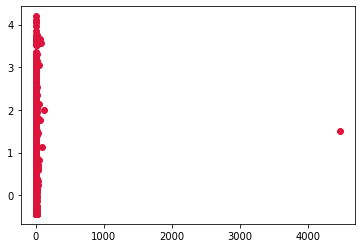

In [53]:
plt.scatter(X, y, c = 'crimson')

In [54]:
list2 = list(x_train)
list3 = list(x_test)

In [55]:
type(list2)

list

In [57]:
list2[-1]

4.584424239075691

In [58]:
# Test the function above against the previous data.
#predictions = random_algorithm([x_train], [x_test])
predictions = the_real_random_algo(list2, list3)
predictions0 = the_real_random_algo([x_train, y_train], [x_test, y_test])
predictions02 = the_real_random_algo(y_train, y_test)
print(predictions0)
print(len(predictions0))
print((predictions02))

[array([ 2.14755861e+01, -4.52660169e-03,  1.38715049e+01, ...,
       -3.95095648e-02,  8.14459594e-02,  4.58442424e+00]), array([ 2.14755861e+01, -4.52660169e-03,  1.38715049e+01, ...,
       -3.95095648e-02,  8.14459594e-02,  4.58442424e+00])]
2
[0.8292682926829268, 1.121951219512195, -0.39512195121951216, 0.0, -0.08292682926829269, -0.4390243902439024, -0.034146341463414595, 0.10731707317073173, 0.0, 0.07317073170731707, -0.2341463414634146, -0.14634146341463414, 2.0926829268292684, -0.4390243902439024, -0.14634146341463414, -0.4390243902439024, 1.7819512195121947, -0.4390243902439024, -0.14634146341463414, -0.19512195121951215, -0.2439024390243902, 0.32195121951219513, 0.6829268292682927, 2.707317073170732, 0.7804878048780487, 2.878048780487805, -0.0926829268292683, -0.4390243902439024, -0.3756097560975609, 0.14634146341463414, -0.4390243902439024, 1.2229268292682927, 4.053658536585366, 0.8780487804878049, 0.7560975609756097, 0.0, 0.6341463414634146, -0.4390243902439024, 0.2926829

In [61]:
#predictions01 = the_real_random_algo(x_train, x_test)
#some_mse = mean_squared_error(y_test, predictions0)
#print(some_mse)

In [62]:
# Will name the performance metrics for the prediction set as "some" so as to imply generality.
#some_mse = mean_squared_error(y_train,predictions02)
#some_r2 = r2_score(w2_train, y_svr_train_pred)

Did calculations on the training and testing lists before converting them to a dataframe.

In [63]:
x_train, y_train = pd.DataFrame(x_train), pd.DataFrame(y_train)
x_test, y_test = pd.DataFrame(x_test), pd.DataFrame(y_test)
print('\nTraining x shape: ', x_train.shape)
print('Training y shape: ', y_train.shape)
print('Test x shape: ', x_test.shape)
print('Test y shape: ', y_test.shape)


Training x shape:  (1407, 1)
Training y shape:  (1407, 1)
Test x shape:  (351, 1)
Test y shape:  (351, 1)


Want to establish a baseline to compare to the ML model against. Will create a funciton using the Random Prediction Algorithm.

In [38]:
knn_r_acc = []
for j in range(1, 60, 1):
    knn = KNeighborsRegressor(n_neighbors = j)
    knn.fit(x_train, y_train)
    
    test_score = knn.score(x_test, y_test)
    train_score = knn.score(x_train, y_train)
    
    knn_r_acc.append((j, test_score, train_score))
   
results = pd.DataFrame(knn_r_acc, columns = ['k', 'Test Score', 'Train Score'])
print(results)
print(results.iloc[:,1].max())
print(results.loc[results['Test Score'] == results.iloc[:,1].max(), 'k'].iloc[0])

NameError: name 'x_train' is not defined

According to the results above, k = 29 seems to be the best k. What is concerning is that I feel if I extended the 'for' loop to a higher value, perhaps I would see a better performing k value.

Now, by adjusting the range of for loop to 45, found the optimal k to be k = 40.

Will now create the kNN model.

In [65]:
model_knn = KNeighborsRegressor(n_neighbors = 40)
model_knn.fit(x_train, y_train)
y_knn_train_pred = model_knn.predict(x_train)
y_knn_test_pred = model_knn.predict(x_test)

For model performace, first the training mean square error and R2 score.

In [66]:
knn_train_mse = mean_squared_error(y_train, y_knn_train_pred)
knn_train_r2 = r2_score(y_train, y_knn_train_pred)
# Now, test mean square and r2 score.
knn_test_mse = mean_squared_error(y_test, y_knn_test_pred)
knn_test_r2 = r2_score(y_test, y_knn_test_pred)
# Consolidate the results.
knn_results = pd.DataFrame(['k Nearest Neighbor', knn_train_mse, knn_train_r2, knn_test_mse, knn_test_r2]).transpose()
#results1 = pd.DataFrame(columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2'])
results1 = pd.DataFrame()
results1 = pd.concat([results1, knn_results])
print(results1)
#knn_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
#print(knn_results)

                    0         1         2         3         4
0  k Nearest Neighbor  0.811922  0.022385  0.669317 -0.053437


In [67]:
len(y_knn_test_pred)

351

In [68]:
len(y_test)

351

c:\users\joepb\miniconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


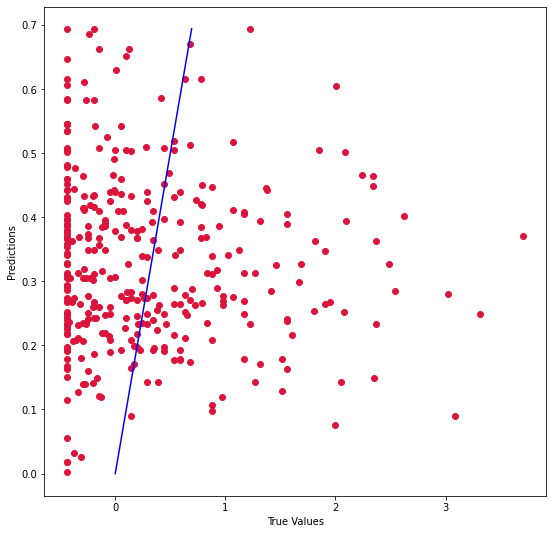

In [69]:
true_values = y_test
predicted_values = y_knn_test_pred
plt.figure(figsize = (9,9))
plt.scatter(true_values, predicted_values, c = 'crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_values), max(true_values))
p2 = min(min(predicted_values), min(true_values))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.xlabel('True Values', fontsize = 10)
plt.ylabel('Predictions', fontsize = 10)
#plt.axis('equal')
plt.show()
plt.close()

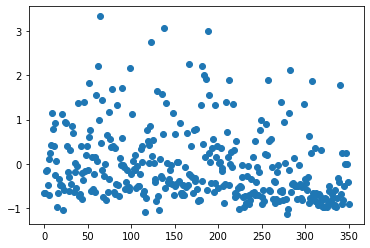

In [70]:
g = plt.plot(true_values - predicted_values, marker = 'o', linestyle = '')

In [71]:
#from yellowbrick.regressor import prediction_error
#model = Lasso()
#visualizer = prediciton_error(model, x_train, y_train, x_test, y_test)

In [72]:
#Set plot size
#plt.subplots(figsize=(10,5))
#Set X-Axis range
#plt.xlim(min(true_values), max(true_values))
#plt.title('Model Error Distribution')
#plt.ylabel('No. of Predictions')
#plt.xlabel('Error')
#plt.hist(predictions['error'], bins=np.linspace(min(test_values), max(test_values), num=41, dtype=int));
#plt.show()

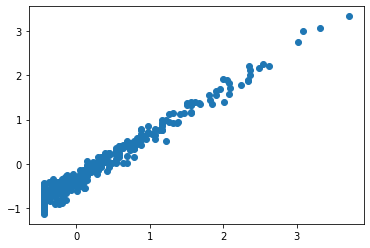

In [73]:
residuals = true_values - predicted_values
plt.scatter(true_values, residuals)


There is an obvious positive linear relationship which indicates that the kNN model is not best supervised learning model for this data.

In [74]:
w1 = x6.iloc[:, 0:1].values
w2 = x6.iloc[:, 1:2].values
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
w3 = sc_X.fit_transform(w1)
w4 = sc_y.fit_transform(w2)
w1_train, w1_test = tts(w3)
w2_train, w2_test = tts(w4)

In [75]:
print(len(w1_train))
print(len(w1))
print(len(w1_test))

1407
1758
351


In [76]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(w1_train, w2_train)
y_svr_train_pred = regressor.predict(w1_train)
y_svr_test_pred = regressor.predict(w1_test)
# Model performance
svr_train_mse = mean_squared_error(w2_train, y_svr_train_pred)
svr_train_r2 = r2_score(w2_train, y_svr_train_pred)
# Test results
svr_test_mse = mean_squared_error(w2_test, y_svr_test_pred)
svr_test_r2 = r2_score(w2_test, y_svr_test_pred)
# Consolidate the results.
#svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2])
#results2 = pd.concat([knn_results, svr_results.T], ignore_index = False)
#print(results2)

c:\users\joepb\miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
results2 = pd.concat([knn_results,svr_results.T], ignore_index = True)
results2.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
results2

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.811922,0.022385,0.669317,-0.053437
1,SVR,1.091002,-0.111827,1.176758,-0.094596


Now want to model using Random Forest.

In [78]:
from sklearn.ensemble import RandomForestRegressor

The line above should be moved to the top of the script.

In [79]:
rf = RandomForestRegressor(max_depth=2)
rf.fit(w1_train, w2_train)
print(rf)

RandomForestRegressor(max_depth=2)


C:\Users\joepb\AppData\Local\Temp\ipykernel_3728\307795354.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(w1_train, w2_train)


Now going to apply the constructed model to make predictions on the training and testing sets.

In [80]:
y_rf_train_pred = rf.predict(w1_train)
y_rf_test_pred = rf.predict(w1_test)

In [81]:
y_rf_test_pred

array([-0.04541311,  0.05533729, -0.10664199, -0.01035017,  0.05441368,
        0.15284272, -0.03286896, -0.00773347,  0.15284272, -0.01129409,
       -0.05198764,  0.14948012, -0.04347065, -0.08994697,  0.05611852,
       -0.01890731, -0.01824517, -0.00809255, -0.03500712,  0.04447919,
       -0.08227061, -0.08994697, -0.01035017, -0.0094446 , -0.0095295 ,
        0.01875568, -0.01035017, -0.05198764, -0.00189365, -0.04143537,
       -0.01035017, -0.09774613,  0.14675358, -0.00809255, -0.00809255,
       -0.01035017, -0.02227787, -0.0095295 , -0.00189365, -0.00773347,
        0.08648906, -0.00189365,  0.14675358, -0.04143537, -0.01035017,
       -0.02227787, -0.00809255, -0.00035967, -0.01824517,  0.005211  ,
        0.00381204, -0.00035967,  0.16664328, -0.0241453 , -0.00035967,
       -0.00035967, -0.01129409, -0.00751235, -0.08994697, -0.01824517,
       -0.01824517, -0.07789619,  0.03224642, -0.01730609, -0.00506674,
       -0.02227787, -0.0241453 , -0.00506674, -0.02039013, -0.01

In [82]:
# Model performance metrics for random forest model.
rf_train_mse = mean_squared_error(w2_train, y_rf_train_pred)
rf_train_r2 = r2_score(w2_train, y_rf_train_pred)
rf_test_mse = mean_squared_error(w2_test, y_rf_test_pred)
rf_test_r2 = r2_score(w2_test, y_rf_test_pred)

In [83]:
rf_results = pd.DataFrame(['Random Forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

In [84]:
results2 = pd.concat([results2, rf_results], ignore_index = True)
results2

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.811922,0.022385,0.669317,-0.053437
1,SVR,1.091002,-0.111827,1.176758,-0.094596
2,Random Forest,0.963474,0.018135,1.062314,0.011857


Now want to compute confidence intervals as a standard practice while computing metrics.

Will compare the R-squared value for kNN and Random Forest models.

In [85]:
from sklearn.utils import resample
def r2_ci(test_data): # The function will be set up for a 95% confidence interval.
    bootstrap_iter = 1000
    sample_size = 10000
    #sample_size = bootstrap_iter
    r2_metrics = []
    confidence = 0.95
    alpha_level = 0.95 * 100
    lower = ((1.0 - confidence)/2.0) * 100 # Should be 2.5 as the lower bound.
    upper = alpha_level + (((1.0 - confidence)/2.0) * 100) # Should be 97.5 as the upper bound
    for i in range(bootstrap_iter):
        sample = resample(predictions, n_samples = sample_size)
        #r2 = r2_score(test_data, predictions)
        r2 = r2_score(test_data, sample)
        r2_metrics.append(r2)
    confidence_interval = np.percentile(r2_metrics, [lower, upper])
    return confidence_interval

In [86]:
95 + (((1.0 - 0.95)/2.0) * 100)

97.5

In [87]:
#r2_ci(y_test, y_knn_test_pred)

In [88]:
(0.95*100)+((1.0-.95)/2.0)*100

97.5

In [89]:
type(w2_test)

numpy.ndarray

In [90]:
#print(true_values02.shape)
#print(residuals1_svr.shape)

In [91]:
w2_test.shape

(351, 1)

In [92]:
#print(residuals1_rf.shape)

In [93]:
#residuals1_rf

In [94]:
#import seaborn as sns
#sns.set_theme(style="whitegrid")
#sns.residplot(x=w2_test, y=y_svr_test_pred, lowess=True, color="g")

In [95]:
#plt.scatter(true_values02, residuals1_svr)
#plt.scatter(w2_test, (y_svr_test_pred-w2_test), color = 'violet')
#plt.axis("equal")

Will now study the relationship between planet mass and temperature.

In [96]:
path3 = 'D:\\PS_2022.04.14_19.39.14.csv'
#path3 = 'E:\\PS_2022.04.14_19.39.14.csv'
raw_data2 = pd.read_csv(path3, skiprows = 28) #  <- notice had to skip first 29 lines.

In [97]:
print(raw_data2)
raw_data2.columns

         pl_name hostname   pl_orbper  pl_orbpererr1  pl_orbpererr2  \
0       11 Com b   11 Com   326.03000          0.320         -0.320   
1       11 Com b   11 Com         NaN            NaN            NaN   
2       11 UMi b   11 UMi         NaN            NaN            NaN   
3       11 UMi b   11 UMi   516.21997          3.200         -3.200   
4       11 UMi b   11 UMi   516.22000          3.250         -3.250   
...          ...      ...         ...            ...            ...   
32320  ups And d  ups And  1282.41000          0.930         -0.940   
32321  ups And d  ups And  1281.50700          1.055         -1.055   
32322  ups Leo b  ups Leo   385.20000          2.800         -1.300   
32323   xi Aql b   xi Aql         NaN            NaN            NaN   
32324   xi Aql b   xi Aql   136.75000          0.250         -0.250   

       pl_orbperlim  pl_bmassj  pl_bmassjerr1  pl_bmassjerr2  pl_bmassjlim  \
0               0.0      19.40           1.50          -1.50         

Index(['pl_name', 'hostname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2',
       'pl_orbperlim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2',
       'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2',
       'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim'],
      dtype='object')

In [98]:
type(raw_data2) #<- already a pandas data frame.

pandas.core.frame.DataFrame

In [99]:
df4 = raw_data2.loc[:, ['pl_name','pl_bmassj','pl_eqt']]
df4.reset_index(drop=True, inplace=True)

In [100]:
df4

,pl_name,pl_bmassj,pl_eqt
0,11 Com b,19.40,NaN
1,11 Com b,17.10,NaN
2,11 UMi b,10.80,NaN
3,11 UMi b,14.74,NaN
4,11 UMi b,10.50,NaN
...,...,...,...
32320,ups And d,4.10,NaN
32321,ups And d,10.25,NaN
32322,ups Leo b,0.51,NaN
32323,xi Aql b,2.02,NaN


In [101]:
df4 = df4.rename(columns={'pl_name':'planetname','pl_bmassj':'planetmass', 'pl_eqt':'temperature'})
df4 = df4.dropna()

In [102]:
df4

,planetname,planetmass,temperature
23,1RXS J160929.1-210524 b,12.00000,1700.0
24,1RXS J160929.1-210524 b,8.00000,1700.0
25,1RXS J160929.1-210524 b,8.00000,1800.0
26,1RXS J160929.1-210524 b,8.00000,1800.0
30,2M0437 b,4.00000,1450.0
...,...,...,...
32265,kap And b,13.61600,1900.0
32284,pi Men c,0.01422,1147.0
32285,pi Men c,0.01517,1170.0
32289,rho CrB b,1.04490,614.0


In [103]:
print(type(df4.iloc[0][1]))
print(type(df4.iloc[0][2]))

<class 'numpy.float64'>
<class 'numpy.float64'>


Notice both of the above are float data type which will make computation easier.

In [104]:
df4.reset_index(drop=True, inplace=True)

In [105]:
df4

,planetname,planetmass,temperature
0,1RXS J160929.1-210524 b,12.00000,1700.0
1,1RXS J160929.1-210524 b,8.00000,1700.0
2,1RXS J160929.1-210524 b,8.00000,1800.0
3,1RXS J160929.1-210524 b,8.00000,1800.0
4,2M0437 b,4.00000,1450.0
...,...,...,...
1145,kap And b,13.61600,1900.0
1146,pi Men c,0.01422,1147.0
1147,pi Men c,0.01517,1170.0
1148,rho CrB b,1.04490,614.0


In [106]:
x7 = df4.groupby('planetname')['planetmass'].mean()
x8 = df4.groupby('planetname')['temperature'].mean()
x8

planetname
1RXS J160929.1-210524 b        1750.0
2M0437 b                       1450.0
2MASS J12073346-3932539 b      1200.0
2MASS J21402931+1625183 A b    2075.0
51 Eri b                        700.0
                                ...  
bet Pic b                      1631.0
kap And b                      1790.0
pi Men c                       1158.5
rho CrB b                       614.0
rho CrB c                       448.0
Name: temperature, Length: 855, dtype: float64

In [107]:
df5 = pd.concat([x7, x8], axis = 1)
df5

,planetmass,temperature
planetname,,
1RXS J160929.1-210524 b,9.000000,1750.0
2M0437 b,4.000000,1450.0
2MASS J12073346-3932539 b,4.500000,1200.0
2MASS J21402931+1625183 A b,20.950000,2075.0
51 Eri b,2.000000,700.0
...,...,...
bet Pic b,13.500000,1631.0
kap And b,13.208000,1790.0
pi Men c,0.014695,1158.5


In [108]:
mass = df5['planetmass']
temp = df5['temperature']
mass_med = statistics.median(list(mass))
temp_med = statistics.median(list(temp))
print('\nThe median of the planet mass: %.2f' % mass_med)
print('\nThe median of the temperature: %.2f' % temp_med)
iqr_mass = stats.iqr(mass, interpolation = 'midpoint')
iqr_temp = stats.iqr(temp, interpolation = 'midpoint')
print('\nThe interquartile range of the planet mass: %.2f' % iqr_mass)
print('\nThe interquartile range of the temperature: %.2f' % iqr_temp)
print(statistics.mean(list(mass)))


The median of the planet mass: 0.58

The median of the temperature: 1192.00

The interquartile range of the planet mass: 1.35

The interquartile range of the temperature: 914.50
1.6814424873294347


(array([0.2896774 , 0.02105327, 0.00740763, 0.00506838, 0.00389875,
        0.00233925, 0.0015595 , 0.00116963, 0.00077975, 0.00038988]),
 array([9.1000000e-04, 3.0008190e+00, 6.0007280e+00, 9.0006370e+00,
        1.2000546e+01, 1.5000455e+01, 1.8000364e+01, 2.1000273e+01,
        2.4000182e+01, 2.7000091e+01, 3.0000000e+01]),
 <BarContainer object of 10 artists>)

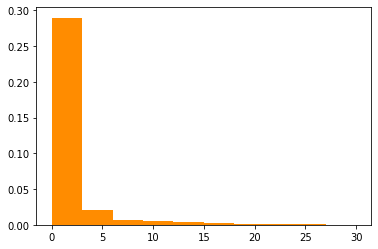

In [109]:
plt.hist(df5.planetmass, density = True, color = "darkorange")

(array([ 99., 170., 180., 214., 128.,  45.,  16.,   0.,   2.,   1.]),
 array([  50.,  450.,  850., 1250., 1650., 2050., 2450., 2850., 3250.,
        3650., 4050.]),
 <BarContainer object of 10 artists>)

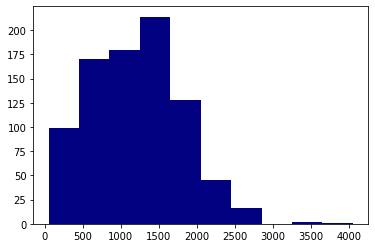

In [110]:
plt.hist(df5.temperature, color = "navy")

Note that the trend in this distribution is not as skewed as the other metrics. That is, it more closely resembles a normal distribution.

In [111]:
x9 = df5[['planetmass', 'temperature']]

In [112]:
x9

,planetmass,temperature
planetname,,
1RXS J160929.1-210524 b,9.000000,1750.0
2M0437 b,4.000000,1450.0
2MASS J12073346-3932539 b,4.500000,1200.0
2MASS J21402931+1625183 A b,20.950000,2075.0
51 Eri b,2.000000,700.0
...,...,...
bet Pic b,13.500000,1631.0
kap And b,13.208000,1790.0
pi Men c,0.014695,1158.5


In [113]:
rs2 = RobustScaler().fit(x9)
transformer2 = rs2.transform(x9)
print(type(transformer2))
len(transformer2)

<class 'numpy.ndarray'>


855

In [114]:
x10 = transformer2[:, 0]
y2 = transformer2[:, 1]

In [115]:
x_train2, x_test2 = tts(x10)
y_train2, y_test2 = tts(y2)

In [116]:
type(x_train2)

numpy.ndarray

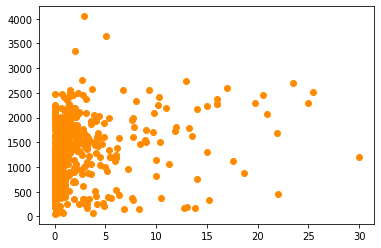

In [117]:
plt.scatter(x9.planetmass, x9.temperature, c = 'darkorange')

Need to convert the above from Pandas dataframes to numpy ndarrays for the Random Prediction Algorithm.

In [118]:
#x_train2.to_numpy
#x_test2.to_numpy
#y_train2.to_numpy
#y_test2.to_numpy

In [119]:
#predictions2 = random_algorithm([x_train2], [x_test2])
predictions2 = the_real_random_algo(y_train2, y_test2)
#predictions2 = random_algorithm([x_train2, y_train2], [x_test2, y_test2])
print(predictions2)

[0.4953526517222526, -0.7337342810278841, 0.28430836522689995, -0.8693275013668671, -0.9261891744122471, 0.6003280481137233, 0.22525970475669765, 0.4920721705850191, 0.9414980863860033, 0.8594860579551667, -0.6681246582832149, 0.4723892837616184, 0.9786768726079825, 0.3805358119190815, -0.7337342810278841, 0.42536905412793874, -0.5817386550027337, -0.7091306724986332, -0.3236741388737015, 1.3756150902132314, -0.31492618917441223, -0.6582832148715145, 1.2881355932203389, -0.48004373974849646, 0.42099507927829416, -0.9294696555494806, 0.055768179332968834, 0.7096774193548387, -0.20120284308365227, 0.6160014579916164, 0.1530891197375615, -0.8419901585565883, -1.0814652815746308, 0.3074539821396028, 0.27665390924002187, 0.15144887916894478, -0.3980317113176599, -0.6856205576817933, 1.4849644614543467, -0.34554401312192456, -0.7960634226353198, 1.039912520503007, 0.29305631492618917, -0.013121924548933843, -0.39475123018042646, 0.2897758337889557, -0.01530891197375615, -0.7916894477856752, 

In [120]:
x_train2, y_train2 = pd.DataFrame(x_train2), pd.DataFrame(y_train2)
x_test2, y_test2 = pd.DataFrame(x_test2), pd.DataFrame(y_test2)
print('\nTraining x2 shape: ', x_train2.shape)
print('Training y2 shape: ', y_train2.shape)
print('Test x2 shape: ', x_test2.shape)
print('Test y2 shape: ', y_test2.shape)


Training x2 shape:  (684, 1)
Training y2 shape:  (684, 1)
Test x2 shape:  (171, 1)
Test y2 shape:  (171, 1)


In [121]:
knn_r_acc2 = []
for n in range(1, 60, 1):
    knn2 = KNeighborsRegressor(n_neighbors = n)
    knn2.fit(x_train2, y_train2)
    
    test_score2 = knn2.score(x_test2, y_test2)
    train_score2 = knn2.score(x_train2, y_train2)
    
    knn_r_acc2.append((n, test_score2, train_score2))
   
outcome = pd.DataFrame(knn_r_acc2, columns = ['k', 'Test Score', 'Train Score'])
print(outcome)
print(outcome.iloc[:,1].max())

     k  Test Score  Train Score
0    1   -1.205766     0.780466
1    2   -0.595845     0.478536
2    3   -0.368213     0.295185
3    4   -0.265730     0.208154
4    5   -0.282119     0.164389
5    6   -0.273346     0.127632
6    7   -0.262001     0.120087
7    8   -0.210585     0.095028
8    9   -0.156664     0.097436
9   10   -0.077781     0.086426
10  11   -0.075158     0.083196
11  12   -0.061698     0.070604
12  13   -0.076483     0.058627
13  14   -0.066278     0.059908
14  15   -0.077387     0.052267
15  16   -0.069560     0.055340
16  17   -0.062415     0.053478
17  18   -0.062628     0.046156
18  19   -0.058909     0.044356
19  20   -0.047323     0.038323
20  21   -0.051108     0.037126
21  22   -0.053170     0.035275
22  23   -0.053001     0.034705
23  24   -0.050601     0.035552
24  25   -0.034774     0.038154
25  26   -0.040550     0.031677
26  27   -0.039291     0.030265
27  28   -0.038263     0.022024
28  29   -0.045544     0.022983
29  30   -0.036217     0.023374
30  31  

The maximum test score for this kNN model occurs when k = 15.
Will not create the second kNN model to help describe the relationship betweeen mass and temperature.

In [122]:
model_knn2 = KNeighborsRegressor(n_neighbors = 15)
model_knn2.fit(x_train2, y_train2)
y_knn_train_pred2 = model_knn2.predict(x_train2)
y_knn_test_pred2 = model_knn2.predict(x_test2)

In [123]:
knn_train_mse_2 = mean_squared_error(y_train2, y_knn_train_pred2)
knn_train_r2_2 = r2_score(y_train2, y_knn_train_pred2)
# Now, test mean square and r2 score.
knn_test_mse_2 = mean_squared_error(y_test2, y_knn_test_pred2)
knn_test_r2_2 = r2_score(y_test2, y_knn_test_pred2)
# Consolidate the results.
knn_results2 = pd.DataFrame(['k Nearest Neighbor', knn_train_mse_2, knn_train_r2_2, knn_test_mse_2, knn_test_r2_2]).transpose()
results3 = pd.DataFrame()
results3 = pd.concat([results3, knn_results2])
print(results2)

               Method Training MSE Training R2  Test MSE   Test R2
0  k Nearest Neighbor     0.811922    0.022385  0.669317 -0.053437
1                 SVR     1.091002   -0.111827  1.176758 -0.094596
2       Random Forest     0.963474    0.018135  1.062314  0.011857


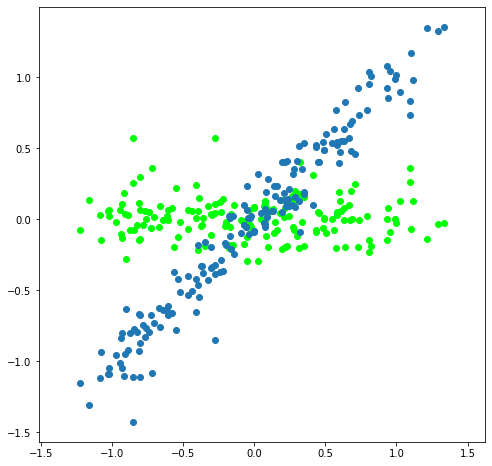

In [124]:
true_values2 = y_test2
predicted_values2 = y_knn_test_pred2
plot2 = plt.figure(figsize=(8,8))
plot2 =plt.scatter(true_values2, predicted_values2, c = 'lime')

residuals2 = true_values2 - predicted_values2
plot2 = plt.scatter(true_values2, residuals2)

plt.axis('equal')
plt.show(plot2)

In [125]:
residuals2.shape

(171, 1)

Notice no pattern so model does describe the data.

In [126]:
w5 = x9.iloc[:, 0:1].values
w6 = x9.iloc[:, 1:2].values
sc2_X = StandardScaler()
sc2_y = StandardScaler()
w7 = sc2_X.fit_transform(w5)
w8 = sc2_y.fit_transform(w6)
w3_train, w3_test = tts(w7)
w4_train, w4_test = tts(w7)

In [127]:
type(w3_train)

numpy.ndarray

In [128]:
regressor2 = SVR(kernel = 'rbf')
regressor2.fit(w3_train, w4_train)
y_svr_train_pred2 = regressor2.predict(w3_train)
y_svr_test_pred2 = regressor2.predict(w3_test)
# Model performance
svr_train_mse_2 = mean_squared_error(w4_train, y_svr_train_pred2)
svr_train_r2_2 = r2_score(w4_train, y_svr_train_pred2)
# Test results
svr_test_mse_2 = mean_squared_error(w4_test, y_svr_test_pred2)
svr_test_r2_2 = r2_score(w4_test, y_svr_test_pred2)
# Consolidate the results.
#svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_r2, svr_test_mse, svr_test_r2]).T
svr_results2 = pd.DataFrame(['SVR', svr_train_mse_2, svr_train_r2_2, svr_test_mse_2, svr_test_r2_2])
#results2 = pd.concat([knn_results, svr_results.T], ignore_index = False)
#print(results2)

c:\users\joepb\miniconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [129]:
results3 = pd.concat([knn_results2,svr_results.T], ignore_index = True)
results3.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']
results3

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.4091,0.052267,0.402588,-0.077387
1,SVR,1.091002,-0.111827,1.176758,-0.094596


Now to add the Random Forest Regressor.

In [130]:
rf2 = RandomForestRegressor(max_depth=2)
rf2.fit(w3_train, w4_train)
y_rf_train_pred2 = rf2.predict(w3_train)
y_rf_test_pred2 = rf2.predict(w3_test)

C:\Users\joepb\AppData\Local\Temp\ipykernel_3728\3546261006.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf2.fit(w3_train, w4_train)


In [131]:
some_prediction = random_algorithm(w3_train, w3_test)
print(some_prediction)

[-0.457556457045124, -0.4725142274694349, -0.4639876720029691, -0.4774422633667478, -0.462154249057926, -0.2184855070296112, -0.371650343121717, -0.31898213740231257, -0.19969576877295883, -0.3101566542817638, -0.22294569742386705, -0.47669636769655943, -0.46651289894746156, 0.6800056132430394, -0.47709636136702305, -0.476531245754304, -0.19969576877295883, 0.09069109519348717, -0.1446551213544822, -0.181219192820584, -0.3961339414561429, -0.40467473157280304, -0.4755106213353631, -0.46474495539331295, 0.34122093861551894, 2.47926539781945, 1.7276758675533543, -0.4782052406171694, -0.4751561785455217, -0.3332167875967463, 3.193844837580018, -0.4634666838058528, -0.3938563974250335, -0.4756942483228713, -0.47698675456052586, -0.4511053135770066, -0.4727562165227402, -0.4738551315177505, -0.47599886983703216, -0.18916212762907797, -0.4752017294261439, 0.1649959692084306, -0.32780762052286144, -0.460243959001833, -0.26916086172179493, -0.3258147694956407, -0.2318660782123788, -0.292220995

In [132]:
some_r2 = r2_score(w3_test, some_prediction)
print(some_r2)

-0.7903680467805392


In [133]:
# Model performance metrics for random forest model.
rf2_train_mse = mean_squared_error(w4_train, y_rf_train_pred2)
rf2_train_r2 = r2_score(w4_train, y_rf_train_pred2)
rf2_test_mse = mean_squared_error(w4_test, y_rf_test_pred2)
rf2_test_r2 = r2_score(w4_test, y_rf_test_pred2)

In [134]:
rf_results2 = pd.DataFrame(['Random Forest', rf2_train_mse, rf2_train_r2, rf2_test_mse, rf2_test_r2]).transpose()
rf_results2.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

In [135]:
results3 = pd.concat([results3, rf_results2], ignore_index = True)
results3

,Method,Training MSE,Training R2,Test MSE,Test R2
0,k Nearest Neighbor,0.4091,0.052267,0.402588,-0.077387
1,SVR,1.091002,-0.111827,1.176758,-0.094596
2,Random Forest,0.914041,0.053122,1.129268,0.00829


Random Forest model seems to be the best performing of the trio in this scenario. Still need to do further exploraiton of the interpretation of the R2 value.

In [136]:
rf2_rmse = sqrt(rf2_test_mse)
print('The Random Forest 2 model RMSE is: ', rf2_rmse)

The Random Forest 2 model RMSE is:  1.0626701689560059
